In [11]:
import sys
from loguru import logger
logger = 

# --------- midaGAN imports ----------
try:
    import midaGAN
except ImportError:
    logger.warning("midaGAN not installed as a package, importing it from the local directory.")
    sys.path.append('../')
    import midaGAN

from midaGAN.trainer import Trainer
from midaGAN.configs.builders import build_conf
from midaGAN.configs import init_config
from midaGAN.data import build_dataset, build_loader
from midaGAN.nn.gans import build_gan
from midaGAN.utils import communication, environment
environment.set_seed(1)

In [12]:
conf = init_config("../projects/nki_cervix_cbct_to_ct/experiments/ex1.yaml")

In [13]:
print(conf.pretty())

batch_size: 1
project_dir: ../projects/nki_cervix_cbct_to_ct
cuda: true
mixed_precision: false
opt_level: O1
dataset:
  name: CBCTtoCTDataset
  root: /repos/Maastro/nki_cervix
  shuffle: true
  num_workers: 1
  patch_size:
  - 16
  - 128
  - 128
  hounsfield_units_range:
  - -1000
  - 2000
  focal_region_proportion: 0.2
  enable_masking: true
  enable_bounding: true
  ct_mask_threshold: -300
  cbct_mask_threshold: -700
gan:
  is_train: true
  name: RevGAN
  loss_type: lsgan
  norm_type: instance
  weight_init_type: normal
  weight_init_gain: 0.02
  pool_size: 50
generator:
  name: Vnet3D
  in_channels: 1
  use_memory_saving: false
  use_inverse: true
  first_layer_channels: 16
  down_blocks:
  - 2
  - 2
  - 3
  up_blocks:
  - 3
  - 3
  - 3
  is_separable: false
n_iters: 200000
n_iters_decay: 0
discriminator:
  name: PatchGAN3D
  in_channels: 1
  ndf: 64
  n_layers: 2
optimizer:
  beta1: 0.5
  lr_D: 0.0002
  lr_G: 0.0004
  lambda_A: 25.0
  lambda_B: 25.0
  lambda_identity: 0.0
  
  prop

In [14]:
conf.train.dataset.num_workers = 0
conf.train.dataset.patch_size = (32, 32, 32)
dataset = build_dataset(conf)
model = build_gan(conf)

In [15]:
import torch
from midaGAN.utils import sitk_utils
from midaGAN.data.utils.normalization import min_max_normalize, min_max_denormalize
from midaGAN.data.utils.register_truncate import truncate_CT_to_scope_of_CBCT
from midaGAN.data.utils.fov_truncate import truncate_CBCT_based_on_fov
from midaGAN.data.utils.body_mask import apply_body_mask_and_bound, get_body_mask_and_bound
from midaGAN.data.utils import volume_invalid_check_and_replace
from midaGAN.data.utils.stochastic_focal_patching import StochasticFocalPatchSampler
from viz import * 

def get_data(patch_size):
    path_CBCT = "/repos/Maastro/nki_cervix/21713759/CBCT/X01.nrrd"
    path_CT = "/repos/Maastro/nki_cervix/21713759/CT/0/CT.nrrd"
    
    

    # load nrrd as SimpleITK objects
    CBCT = sitk_utils.load(path_CBCT)
    CT = sitk_utils.load(path_CT)

    if CBCT is None or CT is None:
        raise RuntimeError("Suitable replacement volume could not be found!")

    # Subtract 1024 from CBCT to map values from grayscale to HU approx
    CBCT = CBCT - 1024

    slice_filter = sitk.SliceImageFilter()
    slice_filter.SetStart(patch_size)
    slice_filter.SetStop([val * 2 for val in patch_size])

    CBCT = slice_filter.Execute(CBCT)
    CT = slice_filter.Execute(CT)


    show_mid_slices(CT)
    show_mid_slices(CBCT)

    # Mask and bound is applied on numpy arrays!
    CBCT = sitk_utils.get_npy(CBCT)
    CT = sitk_utils.get_npy(CT)

    # Convert array to torch tensors
    CBCT = torch.tensor(CBCT)
    CT = torch.tensor(CT)

    # Extract patches
    CBCT = CBCT[0:patch_size[0], 0:patch_size[1], 0:patch_size[2]]
    CT = CT[0:patch_size[0], 0:patch_size[1], 0:patch_size[2]]

    # Limits the lowest and highest HU unit
    CBCT = torch.clamp(CBCT, -1024, 2048)
    CT = torch.clamp(CT, -1024, 2048)

    # Normalize Hounsfield units to range [-1,1]
    CBCT = min_max_normalize(CBCT, -1024, 2048)
    CT = min_max_normalize(CT, -1024, 2048)

    # Add channel dimension (1 = grayscale)
    CBCT = CBCT.unsqueeze(0)
    CT = CT.unsqueeze(0)

    return {'A': CBCT, 'B': CT}

In [16]:
# Dummy data to test loss values
A = torch.full((1, 32, 32, 32), -1.0)
B = torch.full((1, 32, 32, 32), -1.0)

# A[0, 0:16, 0:16, 0:16] = 0

data = {
    'A': A,
    'B': B
}
# Operating on raw dataset with (CDHW), need to add N dimension

for k, v in data.items():
    data[k] = v.unsqueeze(dim=0)
print("A: ", data['A'].min(), data['A'].max())
print("B: ", data['B'].min(), data['B'].max())

A:  tensor(-1.) tensor(-1.)
B:  tensor(-1.) tensor(-1.)


A:  tensor(-1.) tensor(-0.8939)
B:  tensor(-1.) tensor(-0.9674)


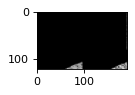

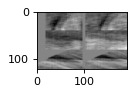

In [8]:
data = get_data(conf.train.dataset.patch_size)
print("A: ", data['A'].min(), data['A'].max())
print("B: ", data['B'].min(), data['B'].max())

# Operating on raw dataset with (CDHW), need to add N dimension

for k, v in data.items():
    data[k] = v.unsqueeze(dim=0)

In [17]:
# Uncomment line below to test masking
# model.setup_masking(None)
model.setup_masking(conf.train.gan.optimizer.loss_mask)

model.set_input(data)
model.forward()
model.mask_current_visuals()
        
discriminators = [ model.networks['D_A'], model.networks['D_B'] ]
# ------------------------ G (A and B) ----------------------------------------------------
model.set_requires_grad(discriminators, False)   # Ds require no gradients when optimizing Gs
model.optimizers['G'].zero_grad(set_to_none=True)                # set G's gradients to zero
model.backward_G(loss_id=0)                      # calculate gradients for G
# ------------------------ D_A and D_B ----------------------------------------------------
model.set_requires_grad(discriminators, True)
model.optimizers['D'].zero_grad(set_to_none=True)                #set D_A and D_B's gradients to zero
model.backward_D('D_A', loss_id=1)               # calculate gradients for D_A
model.backward_D('D_B', loss_id=2)               # calculate graidents for D_B

learning_rates, losses, visuals = model.get_loggable_data()
print(losses)

{'D_A': tensor(1., device='cuda:0', grad_fn=<AddBackward0>), 'G_AB': tensor(1., device='cuda:0', grad_fn=<MseLossBackward>), 'cycle_A': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'idt_A': None, 'inv_A': None, 'D_B': tensor(1., device='cuda:0', grad_fn=<AddBackward0>), 'G_BA': tensor(1., device='cuda:0', grad_fn=<MseLossBackward>), 'cycle_B': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'idt_B': None, 'inv_B': None}


{'D_A': tensor(5.4338, device='cuda:0', grad_fn=<AddBackward0>), 'G_AB': tensor(3.0061, device='cuda:0', grad_fn=<MseLossBackward>), 'cycle_A': tensor(12.3382, device='cuda:0', grad_fn=<MulBackward0>), 'idt_A': None, 'inv_A': None, 'D_B': tensor(5.7199, device='cuda:0', grad_fn=<AddBackward0>), 'G_BA': tensor(2.6451, device='cuda:0', grad_fn=<MseLossBackward>), 'cycle_B': tensor(12.4225, device='cuda:0', grad_fn=<MulBackward0>), 'idt_B': None, 'inv_B': None}